In [1]:
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv(r'./boston.csv')

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
y = data['MEDV']
X = data.drop(columns=['MEDV'])

print(f"{X.shape=}\t\t{y.shape=}")

X.head()

X.shape=(506, 13)		y.shape=(506,)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [5]:
categorical = ['RAD',]
numerical = list(filter(lambda _colname: _colname not in categorical, X.columns))

print(f"Numerical features: {numerical}")
print(f"Categorical features: {categorical}")

Numerical features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Categorical features: ['RAD']


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

X_train.shape, X_val.shape

((379, 13), (127, 13))

In [7]:
ct = ColumnTransformer([
    ('encoding', OneHotEncoder(handle_unknown='error'), categorical),
    ('scaler', StandardScaler(), numerical)
])

X_train = ct.fit_transform(X_train, y_train)
X_val = ct.transform(X_val)

In [8]:
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train, y_train)

print(f"Linear regression R^2 score: {linreg.score(X_val, y_val)}")

Linear regression R^2 score: 0.6333811371465689


In [9]:
catboost = CatBoostRegressor(num_trees=250, depth=3, silent=True)
catboost.fit(X_train, y_train)

print(f"Catboost regression R^2 score: {catboost.score(X_val, y_val)}")

Catboost regression R^2 score: 0.735270139420872


In [19]:
y_preds = linreg.predict(X_val)
y_act = y_val.copy()

print(f"{y_preds.shape=}\t{y_act.shape=}")

y_preds.shape=(127,)	y_act.shape=(127,)


In [20]:
from validation.src import Validation

In [38]:
linreg_val = Validation(y_pred=linreg.predict(X_val), y_act=y_val, kde_eval='direct')
catboost_val = Validation(y_pred=catboost.predict(X_val), y_act=y_val, kde_eval='direct')

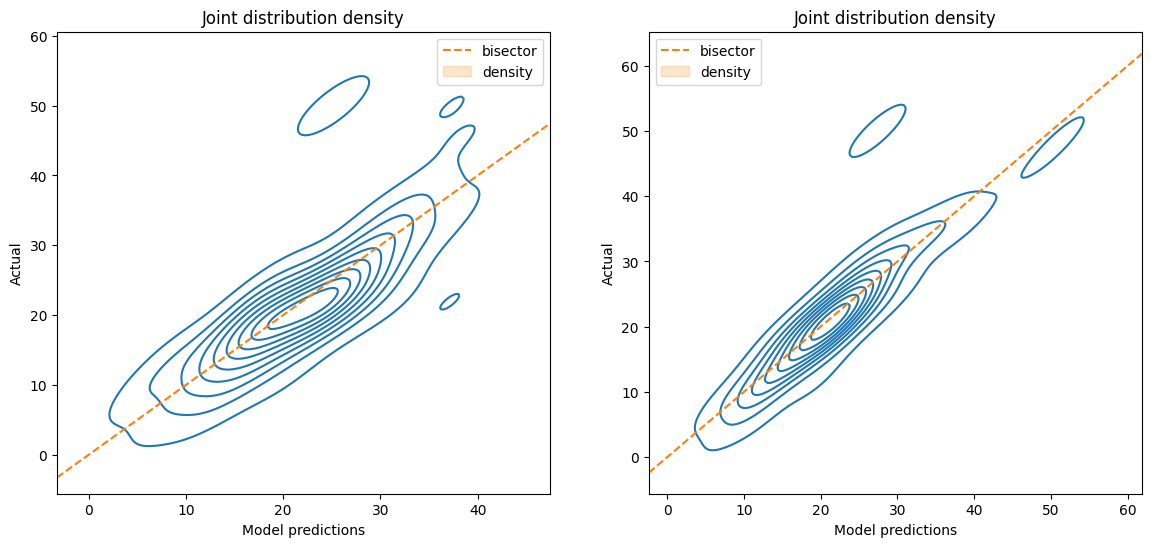

In [39]:
_, ax = plt.subplots(ncols=2, figsize=(14, 6))

linreg_val.plot_joint(title='Joint distribution density', ax=ax[0])
catboost_val.plot_joint(title='Joint distribution density', ax=ax[1])

ax[0].legend(['bisector', 'density'])
ax[1].legend(['bisector', 'density'])

# plt.savefig(r'figures\boston_joint.pdf')

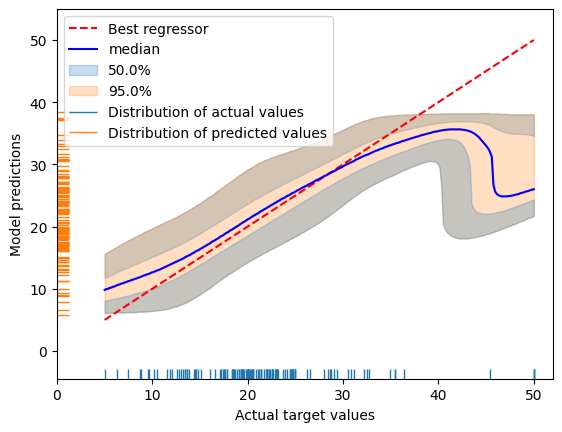

In [57]:
linreg_val.plot_recall_curve(plot_optimal=True)

plt.legend(loc='upper left')
plt.xlim((0, 52))

plt.savefig(r'figures/boston_recall_linreg.pdf')

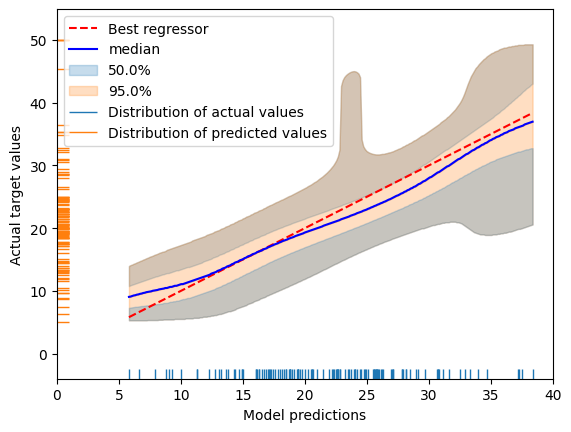

In [58]:
linreg_val.plot_precision_curve(plot_optimal=True)

plt.legend(loc='upper left')
plt.xlim((0, 40))

plt.savefig(r'figures/boston_precision_linreg.pdf')

Text(0.5, 1.0, 'Catboost recall')

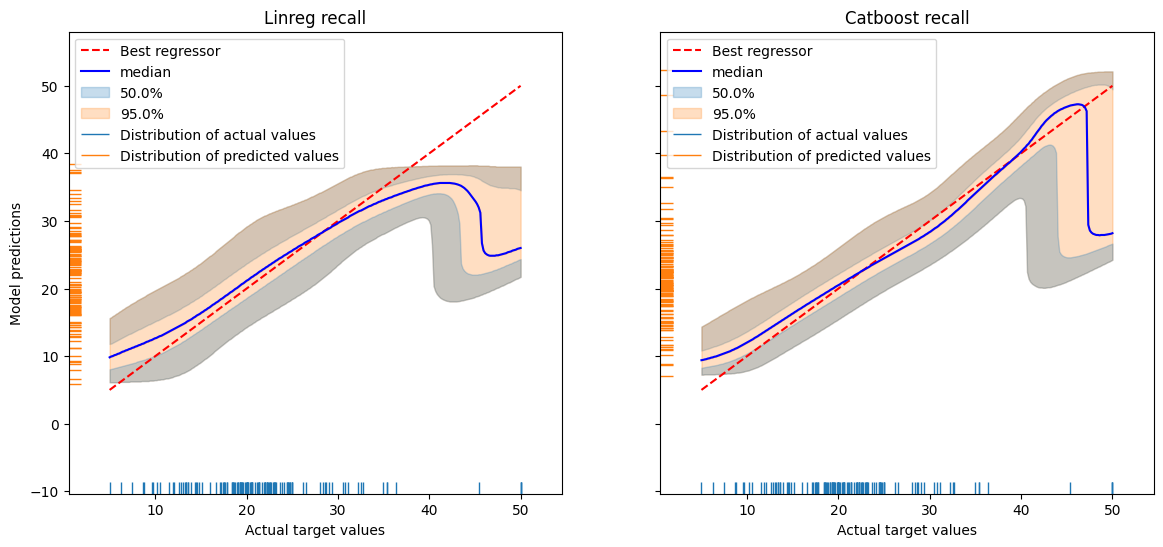

In [43]:
_, ax = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

linreg_val.plot_recall_curve(ax=ax[0], plot_optimal=True)
catboost_val.plot_recall_curve(ax=ax[1], plot_optimal=True)

ax[0].set_title('Linreg recall')
ax[1].set_title('Catboost recall')

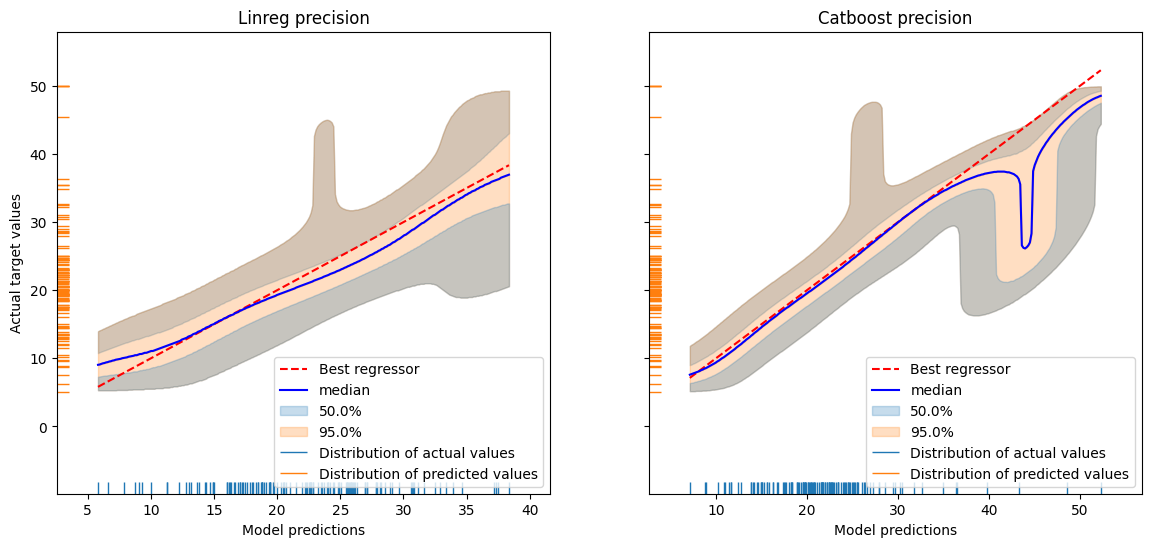

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

linreg_val.plot_precision_curve(ax=ax[0], plot_optimal=True, plot_mode='raw')
catboost_val.plot_precision_curve(ax=ax[1], plot_optimal=True, plot_mode='raw')

ax[0].set_title('Linreg precision')
ax[1].set_title('Catboost precision')

ax[0].save

# ax.set_xlim((-3, 40))
# ax.set_ylim((-5, 70))

fig.savefig(r'figures\boston_precision.pdf')

In [ ]:
# print(f"RMSE score: {val.rmse_score()}")
# print(f"MAE score: {val.mae_score()}")
# print(f"R2 score: {val.r2_score()}")

RMSE score: 4.776910175224043
MAE score: 3.0907095429973523
R2 score: 0.6333811371465689
